In [1]:
import argparse
import sys
import os
import logging
import numpy as np

sys.path.insert(0, '../../../network')
from network import *
from transfer_functions import ErrorFunction, ReLU
from sequences import GaussianSequence
from connectivity import *
from noise import WhiteNoise

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

Build network and connectivity

In [2]:
N_E = 20000
T = 0.5
dt = 1e-3

exc_phi = ReLU(g=12)
exc = Population(N_E, tau=2e-2, phi=exc_phi.phi)

# Build connectivity
conn_EE = SparseConnectivity(source=exc, target=exc, p=0.04)
K_EE = conn_EE.K

# Generate sequences
P, S = 1, 32
sequences = [GaussianSequence(S,exc.size,seed=i) for i in range(P)]
patterns = np.stack([s.inputs for s in sequences])

# Plasticity rule
plasticity = ThresholdPlasticityRule(x_f=1.5, q_f=0.8)

# Synaptic transform
synapse = LinearSynapse(conn_EE.K, A=6.3) #5.8

# Store sequences
conn_EE.store_sequences(patterns, synapse.h_EE, plasticity.f, plasticity.g)

# Rate formulation 2: $ \frac{dx}{dt} = -x + \sum_{j} J_{ij} /phi(x_j) $
net = RateNetwork(exc, c_EE=conn_EE, formulation=2)

INFO:connectivity:Building connections from exc to exc
INFO:connectivity:Storing sequences
100%|██████████| 1/1 [00:03<00:00,  3.83s/it]27.00it/s]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix


Simulate

In [4]:
# Simulate
r0 = np.zeros(exc.size)
r0[:] = exc.phi(plasticity.f(patterns[0,0,:]))

net.simulate(T, r0=r0)

# Correlations
overlaps = sequences[0].overlaps(net, exc, plasticity=plasticity, correlation=False)
correlations = sequences[0].overlaps(net, exc, plasticity=plasticity, correlation=True)

# Save simulation data
logging.info("Saving data")
np.save(
    open("data/data_a.npy", "wb"),
    [correlations,
     net.exc.state.astype(np.float32),
     None,
     {'phi_E': exc_phi.params,
      'phi_I': None}])

INFO:network:Integrating network dynamics
[========================================================================] 100%
INFO:sequences:Computing overlaps
100%|██████████| 32/32 [00:00<00:00, 279.43it/s]
INFO:sequences:Computing correlations
100%|██████████| 32/32 [00:13<00:00,  2.27it/s]
INFO:root:Saving data


Field statistics

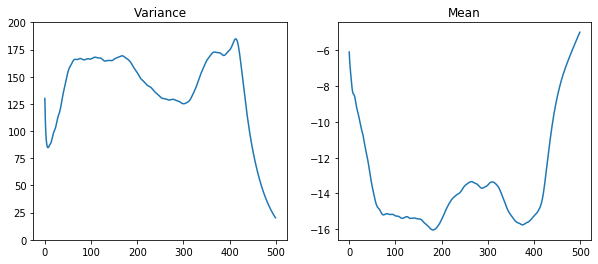

In [11]:
# Field statistics
M = np.mean(net.exc.phi(net.exc.state)**2, axis=0)
field = conn_EE.W.dot(net.exc.phi(net.exc.state))
field_var = field.var(axis=0)
field_mean = field.mean(axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(field_var)
ax[1].plot(field_mean)
ax[0].set_ylim([0,200])
ax[0].set_title("Variance")
ax[1].set_title("Mean");